In [98]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM.MinimalModelV2

In [108]:
using OhMyThreads

In [178]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

# Setup

## Colorings

In [284]:
module MMAnalysisColors
using ColorSchemes
using Makie

ext1 = ColorSchemes.Blues[5]
ext2 = ColorSchemes.Blues[7]
ext3 = ColorSchemes.Blues[9]
stable1 = ColorSchemes.Oranges[4]
stable2 = ColorSchemes.Oranges[5]
unstable1 = ColorSchemes.Greens[4]
unstable2 = ColorSchemes.Greens[5]

other = ColorSchemes.Purples[end]

all = [ext1, ext2, ext3, stable1, stable2, unstable1, unstable2]
markerelements = [MarkerElement(; color=c, marker=:rect) for c in all]

end

function mma_result_coloring1(st::Int)
    map_ = Dict(
        0 => MMAnalysisColors.ext1,
        1 => MMAnalysisColors.ext2,
        11 => MMAnalysisColors.ext3,
        2 => MMAnalysisColors.stable1,
        12 => MMAnalysisColors.stable2,
        3 => MMAnalysisColors.unstable1,
        13 => MMAnalysisColors.unstable2,
    )

    get(map_, st, MMAnalysisColors.other)
end
function mma_result_coloring1_leg()
    yy = [
        "Extinct 1",
        "Extinct 2",
        "Extinct 3",
        "Stable 1",
        "Stable 2",
        "Unstable 1",
        "Unstable 2",
    ]

    MMAnalysisColors.markerelements, yy
end

function mma_result_coloring2(st::Int)
    map_ = Dict(
        0 => MMAnalysisColors.ext1,
        1 => MMAnalysisColors.ext2,
        11 => MMAnalysisColors.ext3,
        2 => MMAnalysisColors.stable1,
        12 => MMAnalysisColors.stable1,
        3 => MMAnalysisColors.unstable1,
        13 => MMAnalysisColors.unstable1,
    )

    get(map_, st, MMAnalysisColors.other)
end
function mma_result_coloring2_leg()
    xx = MMAnalysisColors.markerelements[[1, 2, 3, 4, 6]]
    yy = [
        "Extinct 1",
        "Extinct 2",
        "Extinct 3",
        "Stable",
        # "Stable 2",
        "Unstable",
        # "Unstable 2",
    ]

    xx, yy
end

mma_result_coloring2_leg (generic function with 1 method)

## K v l phase diagram

In [300]:
function plot_Kl_pd!(ax, logKs, ls;
    m=1.,
    k=0.,
    c=1.,
    d=1.,
    DN=1e-8, DI=1.0, DR=1e-8,
    include_legend=true,
    do_decorations=true,
)
    rslts = Matrix{Any}(undef, length(logKs), length(ls))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, l) in enumerate(ls)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m,
                    l=l,
                    k,
                    c,
                    d,
                );
                DN, DI, DR,
            )
        end
    end
    codes = nospacesolstabilities_to_code.(rslts)
    colors = mma_result_coloring2.(codes)
    
    heatmap!(ax, logKs, ls, colors)
    
    if do_decorations
        ax.xlabel = L"\log_{10}(K)"
        ax.ylabel = L"l_\text{influx}"
    end

    if include_legend
        axislegend(ax, mma_result_coloring1_leg()...)
    end
    
    ax
end

plot_Kl_pd! (generic function with 1 method)

# Tiling K v l

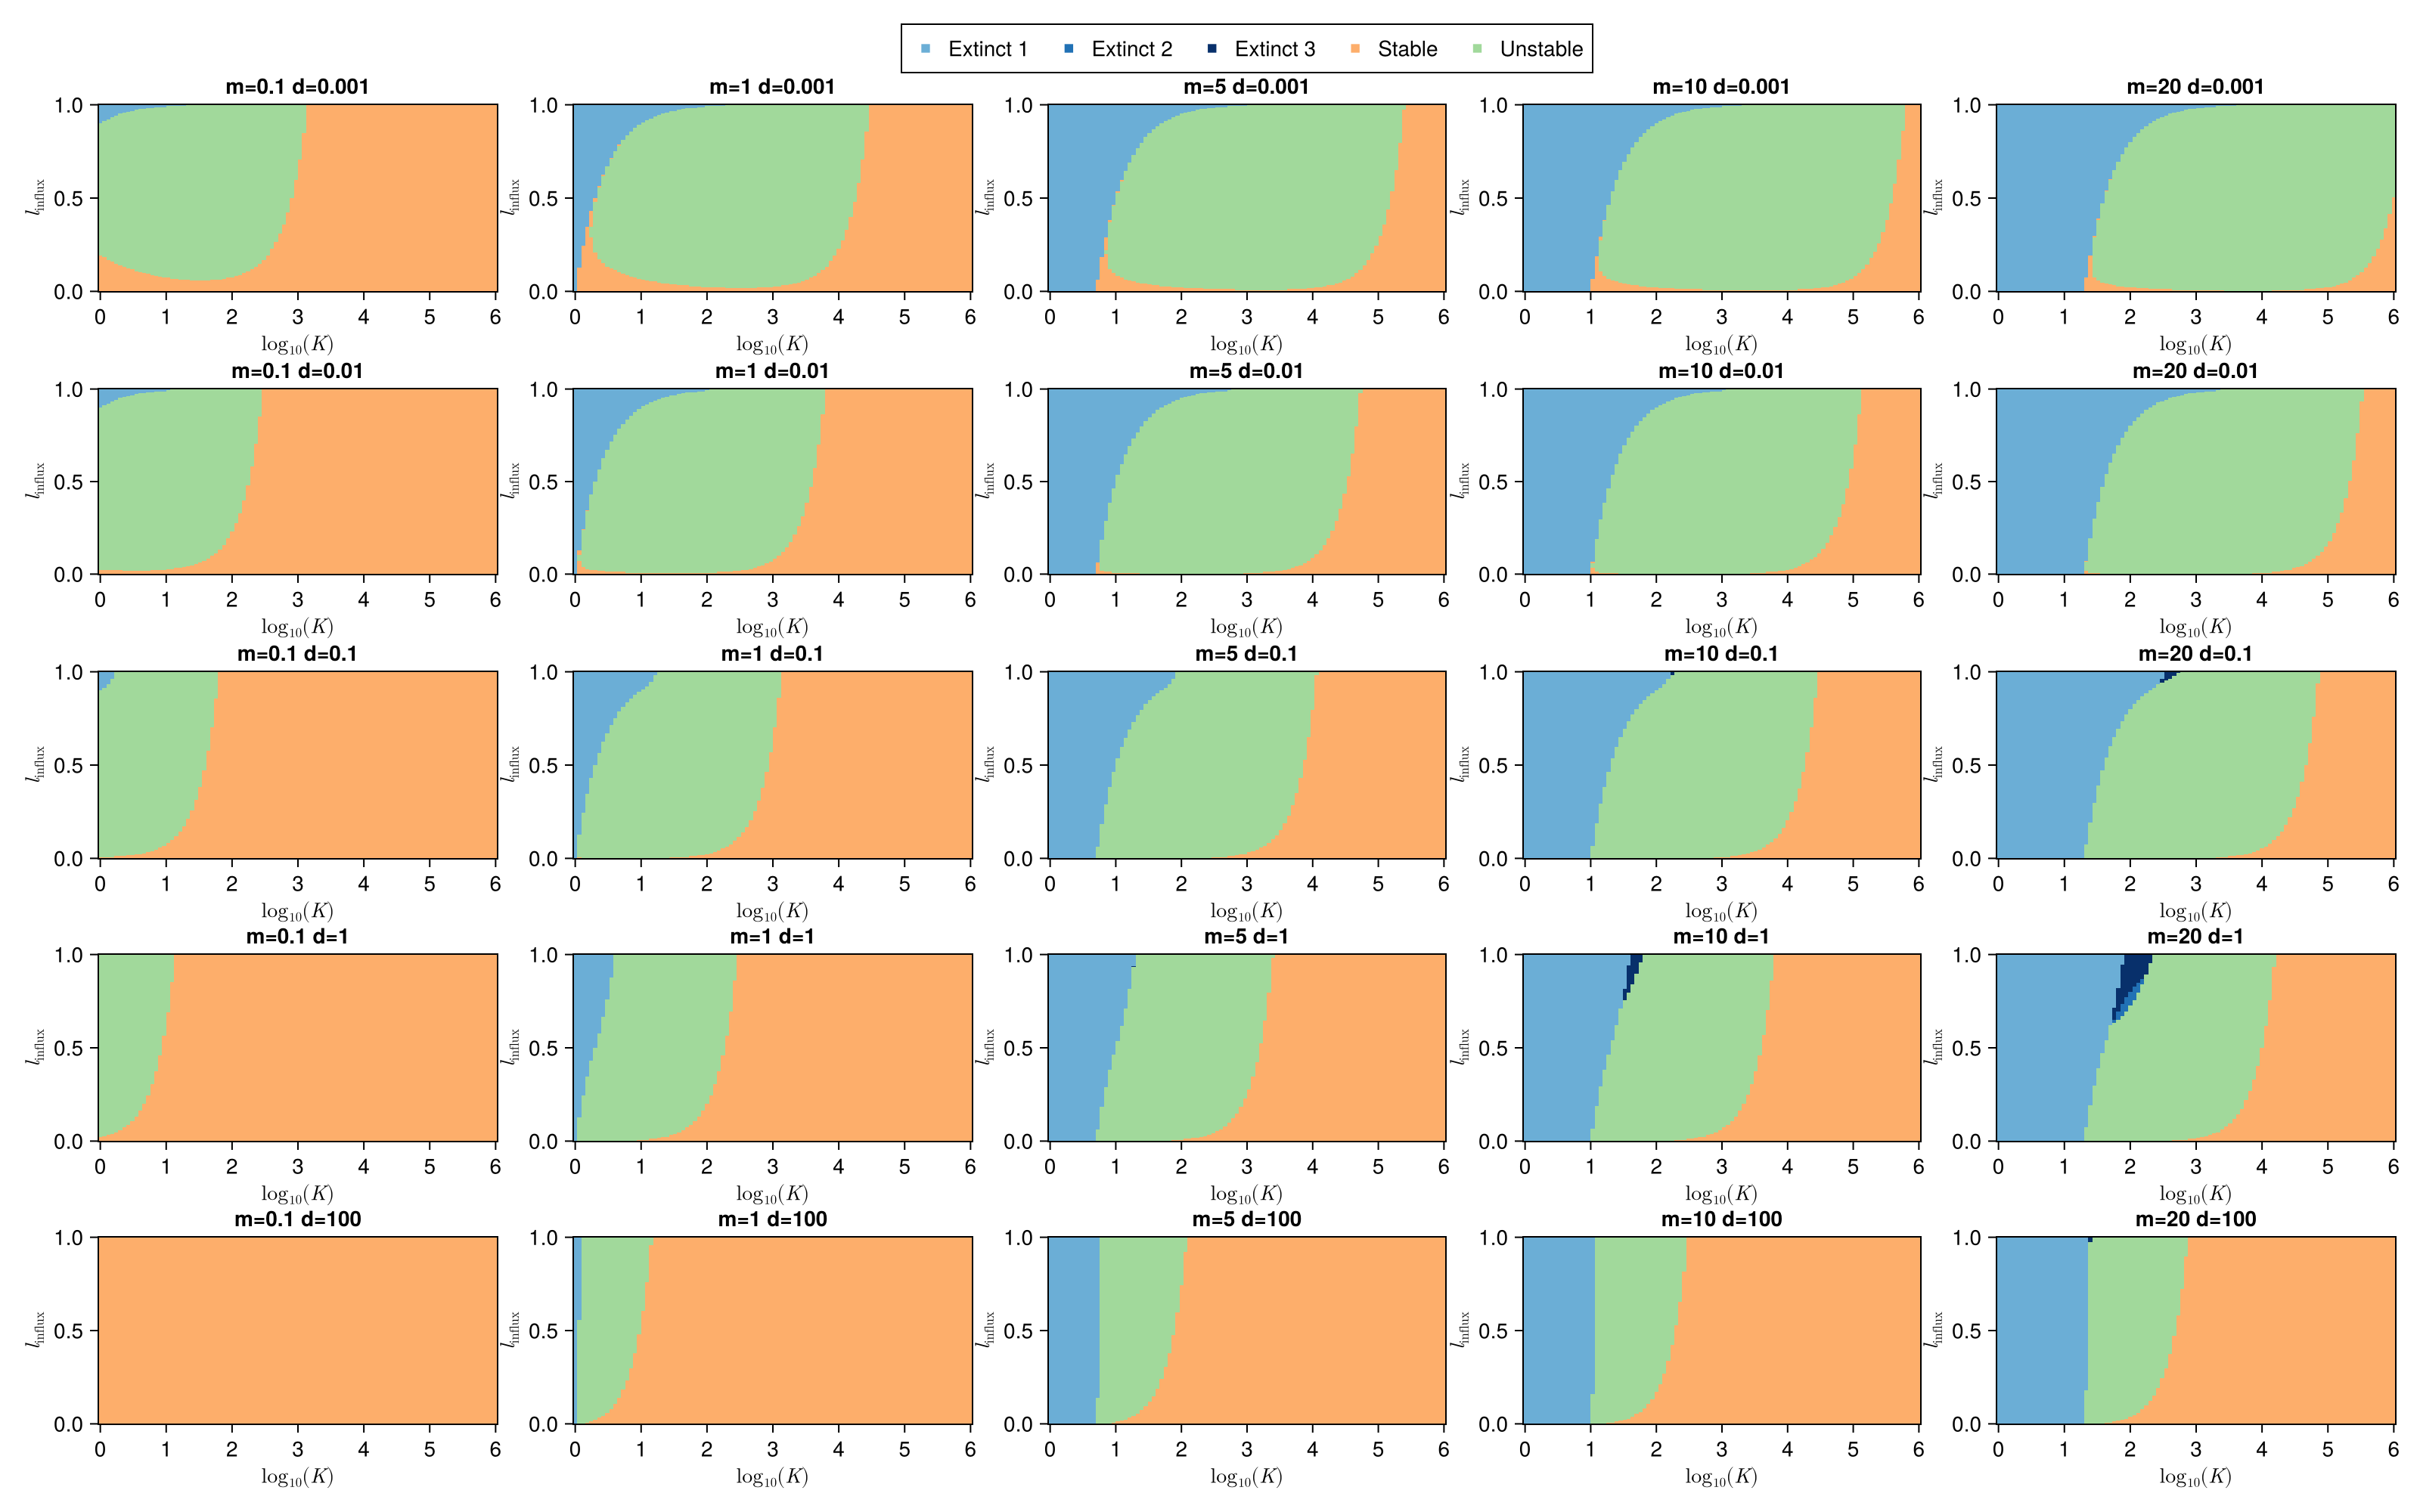

In [301]:
function tiling1()
    f = Figure(;
        size=(1600, 1000)
    )

    ms = range(0.1, 15, 5)
    ms = [0.1, 1, 5, 10, 20]
    # logds = range(-2, 3, 4)
    logds = [-3, -2, -1, 0, 2]

    axs = []
    for (i, m) in enumerate(ms)
        for (j, logd) in enumerate(logds)
            ax = Axis(f[j, i])

            d = 10. ^ logd
            plot_Kl_pd!(ax, range(0, 6, 100), range(0, 1, 200);
                m, d,
                # k=0.5,
                include_legend=false
            )
            ax.title = @sprintf "m=%.3g d=%.3g" m d
        end
    end
    
    Legend(f[0,:], mma_result_coloring2_leg()...;
        orientation=:horizontal
    )
    # Legend(f[:,(length(ms)+1)], leg[1], leg[2]; orientation=:horizontal)

    rowgap!(f.layout, 1.)
    colgap!(f.layout, 1.)

    f
end
xx = tiling1()

Makie.save("../../figures/fig2/tiling_md.pdf", xx)

xx

# Playground 1

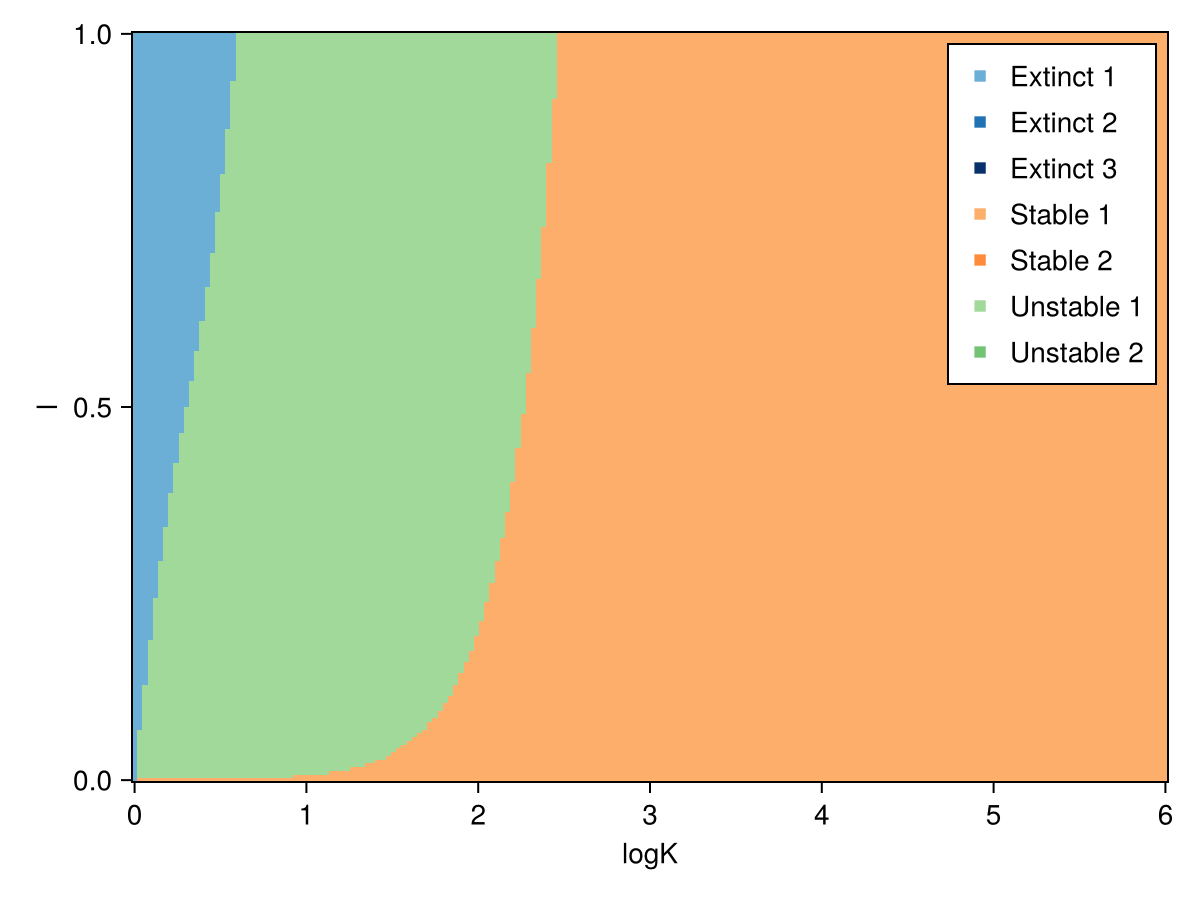

In [244]:
logKs = range(-0, 6, 200)
ls = range(0., 1., 200)

rslts = Matrix{Any}(undef, length(logKs), length(ls))
@tasks for i in 1:length(logKs)
    logK = logKs[i]
    for (j, l) in enumerate(ls)
        rslts[i, j] = analyse_mmp(
            MMParams(;
                K=10 ^ logK,
                m=1.,
                l=l,
                k=0.,
                c=1.,
                d=1e0,
            );
            DN=1e-8, DI=1.0, DR=1e-8,
        )
    end
end
codes = nospacesolstabilities_to_code.(rslts)
colors = mma_result_coloring2.(codes)

fap = heatmap(logKs, ls, colors;
    colormap=Categorical(:viridis),
    axis=(;
        # aspect=DataAspect(),
        xlabel="logK",
        ylabel="l",
    )
)
# Colorbar(fap.figure[1,2], fap.plot)
axislegend(fap.axis, MMAnalysisColors.legend_setup()...)

Makie.save("../../figures/fig2/pd_draft.pdf", fap)

fap

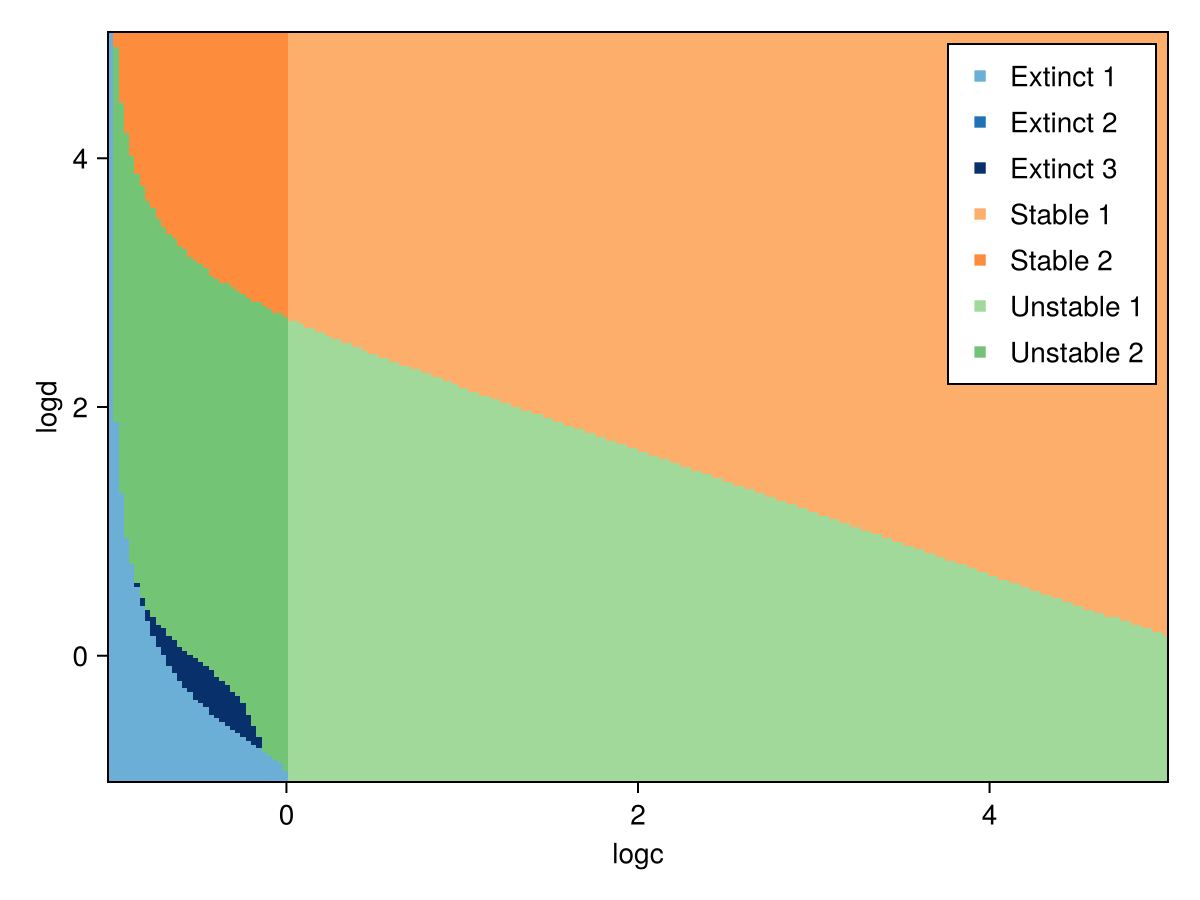

In [196]:
logcs = range(-1., 5., 200)
logds = range(-1., 5., 200)

rslts = Matrix{Any}(undef, length(logcs), length(logds))
@tasks for i in 1:length(logcs)
    logc = logcs[i]
    for (j, logd) in enumerate(logds)
        rslts[i, j] = analyse_mmp(
            MMParams(;
                K=100.,
                m=10.,
                l=0.9,
                k=0.,
                c=10 ^ logc,
                d=10 ^ logd,
            );
            DN=1e-8, DI=1.0, DR=1e-8,
        )
    end
end
codes = nospacesolstabilities_to_code.(rslts)
colors = mma_result_coloring1.(codes)

fap = heatmap(logcs, logds, colors;
    colormap=Categorical(:viridis),
    axis=(;
        # aspect=DataAspect(),
        xlabel="logc",
        ylabel="logd",
    )
)
# Colorbar(fap.figure[1,2], fap.plot)
axislegend(fap.axis, MMAnalysisColors.legend_setup()...)

Makie.save("../../figures/fig2/pd_draft.pdf", fap)

fap

# Raw results testing

In [3]:
mmp = MMParams(;
    K=1.,
    m=1.1,
    l=0.95,
    k=0.1,
    c=2.,
    d=1.,
)
# mm_get_nospace_sol(mmp)
analyse_mmp(mmp)

Any[]

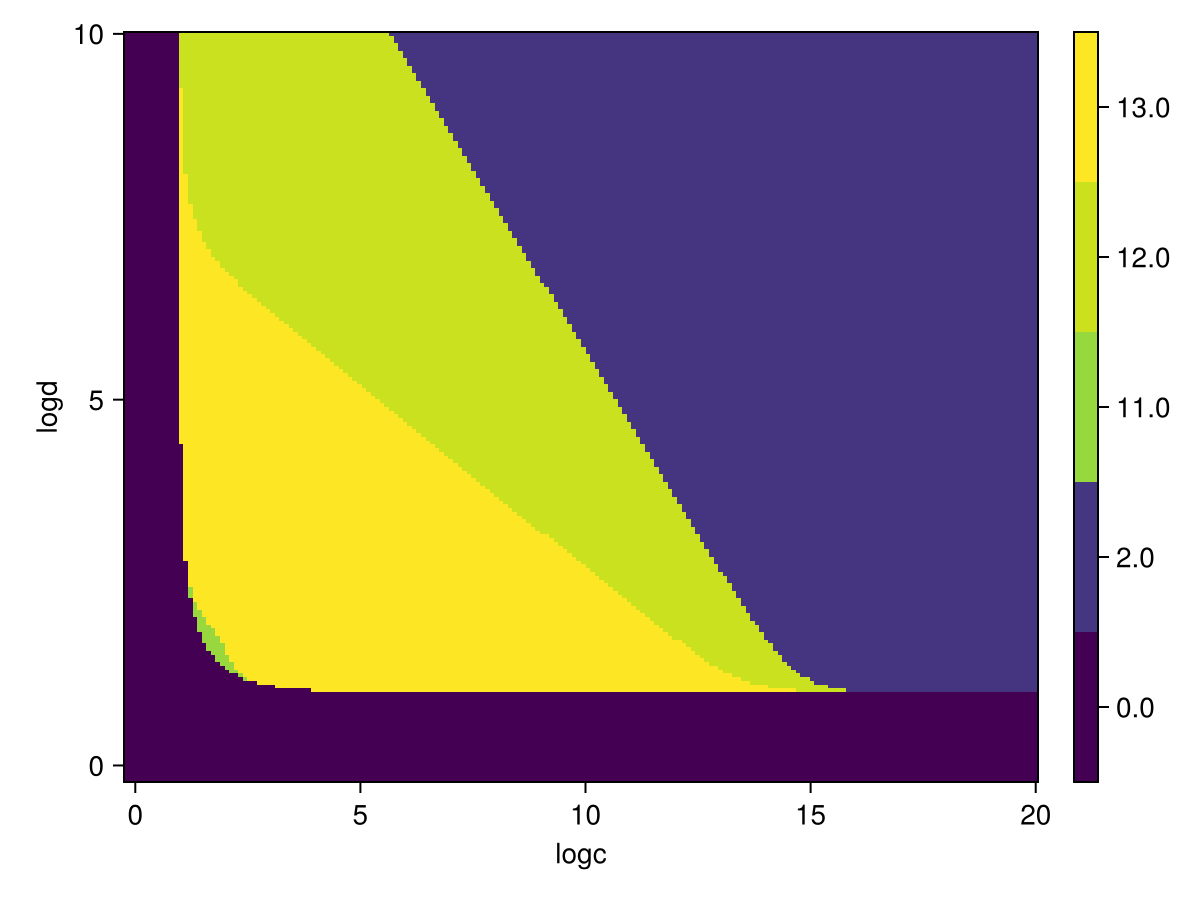

In [27]:
logcs = range(-0.2, 20, 200)
logds = range(-0.2, 10, 200)

rslts = Matrix{Any}(undef, length(logcs), length(logds))
for (i, logc) in enumerate(logcs)
    for (j, logd) in enumerate(logds)
        rslts[i, j] = analyse_mmp(
            MMParams(;
                K=1.,
                m=10.,
                l=1.,
                k=0.0,
                c=10 ^ logc,
                d=10 ^ logd,
            );
            DN=1e-12, DI=1.0, DR=1e-12,
        )
    end
end
codes = nospacesolstabilities_to_code.(rslts)

fap = heatmap(logcs, logds, codes;
    colormap=Categorical(:viridis),
    axis=(;
        xlabel="logc",
        ylabel="logd",
    )
)
Colorbar(fap.figure[1,2], fap.plot)

fap

In [18]:
nospacesolstabilities_list()

doesn't exist        <-> 0
nospace_unstable     <-> 1
stable               <-> 2
unstable             <-> 3


  0.000274 seconds (267 allocations: 21.266 KiB)


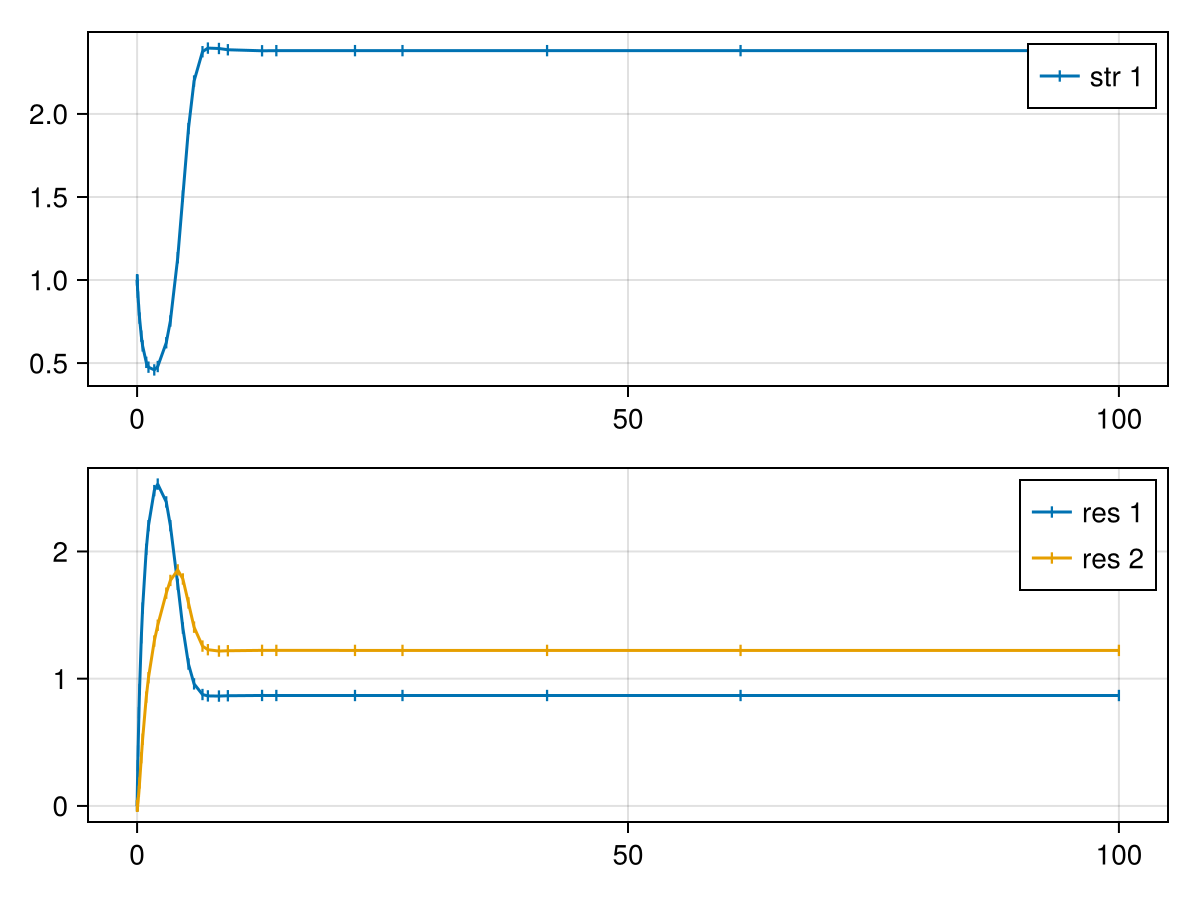

In [142]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 100);
# p = remake_guarantee_positive(p)

@time s = solve(p, TRBDF2();
    callback=make_timer_callback(1.)
)

# @show sort(s.u[end][1:N]; rev=true)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

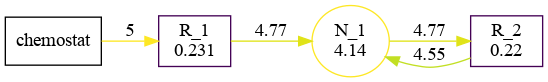

In [96]:
ss = clamp.(s.u[end], minimum(abs, s.u[end]), Inf)
# ss = mm_get_nospace_sol(mmp)[2]
diagram_sfss_v3(ps, ss;
    # strain_threshold=1e-3,
    # colorscale=log10,
)